In [1]:
import pandas as pd
import numpy as np
import os
import sys  
sys.path.insert(1, '../src/')

from pipeline_utils import read_bytes_image
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.io import fits
import gzip
import io
from matplotlib.gridspec import GridSpec

In [2]:
#Initial number of alerts
parquet_files_list_path_2y= "/media3/CRP7/hosts/data/final/SIMBAD_not_in_MANGROVE_with_candidates_2022_2023/"
origi_files2y = os.listdir(parquet_files_list_path_2y)
len(origi_files2y)
events2y = []
events2y_with_one_stamp = []
for of2y in origi_files2y:
    try:
        dfof2y = pd.read_parquet(parquet_files_list_path_2y+of2y)
        events2y.append(list(dfof2y['objectId']))
        for obj in range(len(dfof2y['objectId'])):
            if len(dfof2y['i:fwhm'][obj]) <= 1:
                #print(dfof2y['objectId'][obj])
                events2y_with_one_stamp.append(dfof2y['objectId'][obj])
    except:
        print(of2y)
events2y = sum(events2y,[])
print('Initial number of events: ',len(np.unique(np.array(events2y))))
print('Events with only one stamp: ',len(events2y_with_one_stamp))

_SUCCESS
Initial number of events:  155623
Events with only one stamp:  62983


In [3]:
result_files = os.listdir('/media3/CRP7/hosts/misc_results/possible_hostless_sigma_clip')
#print(np.unique(result_files)`)
result_files = [i for i in result_files if 'final_results' in i]
len(result_files)

200

In [4]:
monster_df = pd.DataFrame()
for rs in result_files:
    dfrf = pd.read_parquet('/media3/CRP7/hosts/misc_results/possible_hostless_sigma_clip/' + rs)
    monster_df = pd.concat([monster_df, dfrf])
monster_df = monster_df.reset_index(drop=True)

In [5]:
#Drop objects with catalog association
idxs_with_catalog_associations = []
for i in range(len(monster_df)):
    if len(np.unique(monster_df['gcvs'][i])) != 1 or len(np.unique(monster_df['3hsp'][i])) != 1 or len(np.unique(monster_df['4lac'][i])) != 1:
        idxs_with_catalog_associations.append(i)
    elif len(np.unique(monster_df['gcvs'][i])) == 1 and np.unique(monster_df['gcvs'][i]) != 'Unknown' or  \
         len(np.unique(monster_df['3hsp'][i])) == 1 and np.unique(monster_df['3hsp'][i]) != 'Unknown' or \
         len(np.unique(monster_df['4lac'][i])) == 1 and np.unique(monster_df['4lac'][i]) != 'Unknown':
        idxs_with_catalog_associations.append(i)
        
monster_df = monster_df.drop(idxs_with_catalog_associations)
monster_df = monster_df.reset_index(drop=True)

In [6]:
unique_tns_class = []
for i in range(len(monster_df['v:tns_classification'])):
    if np.unique(monster_df['v:tns_classification'][i])[0] == 'Unknown':
        unique_tns_class.append(np.unique(monster_df['v:tns_classification'][i])[0])
    else:
        unique_tns_class.append((np.unique(monster_df['v:tns_classification'][i])[0].split(')'))[1])
monster_df['unique_tns_class'] = unique_tns_class

In [7]:
#Remove objects in the MPC
#Found by exploring Kilonova candidates and objects with two stamps
idxs_contaminants = []
objects_in_the_MPC = ['ZTF22abbbydh','ZTF23aaoqpbu','ZTF22abdgjks','ZTF23aasnmmq','ZTF22abhfiew','ZTF22abisymj','ZTF22abfbxop',
                      'ZTF22abhhnzr','ZTF23aasnmru','ZTF22abqmkvz','ZTF23aasnmke','ZTF23aasnisu','ZTF22abmzlbw','ZTF22ablizvx',
                      'ZTF22abngynh','ZTF22abmgjsc','ZTF22aaodjcr','ZTF22abpugfh','ZTF22abjiryo','ZTF23aaoginy','ZTF22abhifxw',
                      'ZTF23aaogjqe','ZTF23aaogjku','ZTF23aaummdv','ZTF23aaogigp','ZTF23aaogiju','ZTF23aaogins','ZTF22aadtiqy',
                      'ZTF23aauyuxn','ZTF22aautkkx','ZTF23aaogiaf','ZTF22aaamcvt','ZTF23aaugvmy','ZTF23aaoghvk','ZTF22aavchkl',
                      'ZTF23aaofwyr','ZTF23aaogjzn','ZTF23aaoggla','ZTF22abbxmvp','ZTF22abjkduc','ZTF23aaogjoi','ZTF23aanbiwv',
                      'ZTF23aaotrxv','ZTF23aaofzxw','ZTF22abpuvwl','ZTF22aavchdb','ZTF23aasoswf','ZTF22aalbvkt','ZTF23aaogpip',
                      'ZTF22aaamctk','ZTF22aaemvon','ZTF23aalvzey','ZTF23aaogfwq','ZTF23aaogpix','ZTF22aarxhdg','ZTF22abkwgdf',
                      'ZTF23aaogfzp','ZTF23aakabyo','ZTF23aaogjqd','ZTF22aaerjna','ZTF23aaogjgw','ZTF22aacqokz','ZTF23aaognat',
                      'ZTF23aaogjor','ZTF22aadgikt','ZTF22abgcphv','ZTF23aaogihz','ZTF23aaogijv','ZTF22aamslae','ZTF23aaofzxv',
                      'ZTF22aahhaxl','ZTF23aaogfbe','ZTF23aaogiin','ZTF23aaoggtk','ZTF23aaogkze','ZTF23aaqzujy','ZTF22aachsxl',
                      'ZTF22abqmgeg','ZTF22aammugu','ZTF23aanxmyw','ZTF22aacbhed','ZTF23aakmhew','ZTF23aaogggc','ZTF23aasnoqs',
                      'ZTF22abdaraj','ZTF23aaogjts','ZTF23aaoggkr','ZTF22abdfcni','ZTF22abgdimv','ZTF23aaogijq','ZTF23aaouwwj',
                      'ZTF23aasnopz','ZTF23aaogfyw','ZTF22abqcija','ZTF23aarkjme','ZTF22aafrcia','ZTF23aaogfgz','ZTF23aaoggtx',
                      'ZTF22aapfnai','ZTF22aaedppl','ZTF22aaeuhge','ZTF23aaepczt','ZTF23aboeoza','ZTF22aahibmv','ZTF22abfuzir',
                      'ZTF22aaaelpn','ZTF23aazxoku','ZTF22abnmsdh','ZTF23aajfils','ZTF22abtovgb','ZTF22aazbpgn','ZTF23aadvyzp',
                      'ZTF22aahwquu','ZTF23absgdtm','ZTF22abyistt','ZTF22aabzkov','ZTF23aaognau','ZTF23aangxzx','ZTF22aadoynn',
                      'ZTF22aarjlzf','ZTF23aamshkr','ZTF23aadirxg','ZTF23aakphgr','ZTF23aaljkky','ZTF23aaognau','ZTF22abbcrpq',
                      'ZTF23aajhrlq','ZTF22aabtgic','ZTF22abymgpf','ZTF23aabvikm','ZTF23aajdlir','ZTF22aaofsmt','ZTF22aafapqe',
                      'ZTF22abvatcm','ZTF22aaofsmt','ZTF23aboelln','ZTF22aatimwz','ZTF22aaoqppp','ZTF23aboulac','ZTF20aaulqdu',
                      'ZTF23aaogdbw','ZTF22aabsgrh','ZTF23aarzltf','ZTF19abupqro','ZTF23abrzafa','ZTF22aaruhor','ZTF23aabrgtk',
                      'ZTF20abfcitt','ZTF23aahtiay','ZTF23aagmcbx','ZTF22abyhyyg','ZTF22abpksdg','ZTF22ablvywo','ZTF23aajikep',
                      'ZTF23aaogdbw','ZTF23aboelln','ZTF22aakfmcf','ZTF22aaivgrf','ZTF22aaagqyn','ZTF23aaovzyu','ZTF19accsvul',
                      'ZTF18aacbuok','ZTF23aaognau','ZTF22abfuwum','ZTF23aabsgmw','ZTF23abmhdzg','ZTF22abhvkwo','ZTF22abqhmws',
                      'ZTF22abghfwt','ZTF23abselxx','ZTF22aawulgl','ZTF22aaqkwkx','ZTF23aamdode','ZTF23aaszssz','ZTF22aaugvhg',
                      'ZTF22abvbfpd','ZTF22aalctia','ZTF23absfxfd','ZTF23aaoglkq','ZTF22aagfmfp','ZTF23aajdtvq','ZTF23aaszssz',
                      'ZTF23absgqco','ZTF22aaestyv','ZTF23aaogdbw','ZTF23aadfgai','ZTF22abghfwt','ZTF22abyrxeg','ZTF23aadbtis',
                      'ZTF20aaulqdu','ZTF23abaqakp','ZTF23aaogdbw','ZTF22aabtnzf','ZTF22abhbepw','ZTF23aavyfyn','ZTF22abhvkwo',
                      'ZTF22abvbfpd','ZTF23aaszssz','ZTF22aagfmaf','ZTF22aayyvzj','ZTF23abbsxrv','ZTF22aazuqah','ZTF23aacjdsf',
                      'ZTF23aaoglkq','ZTF23aarzltf','ZTF23aawzkue','ZTF22abhvkwo','ZTF23aadbtas','ZTF23aaszssz','ZTF23aacviyk',
                      'ZTF22aaphpph','ZTF23aaognau','ZTF23aaoglkq','ZTF23aanlbch','ZTF23absggfo','ZTF23aadwfdv','ZTF22abyixjn',
                      'ZTF23aadfgai','ZTF23aaahvba','ZTF22aayluxo','ZTF23aavmelu','ZTF23aabrgtk','ZTF20abfcitt','ZTF22abfbkow',
                      'ZTF22aarsied','ZTF23aaqqkqg','ZTF22abgnkep','ZTF23abmhhve','ZTF23aacxjwg','ZTF23absaeke','ZTF18acnbnbv',
                      'ZTF20aaulqdu','ZTF22aafftla','ZTF23aadctoq','ZTF20abjtwft','ZTF22aaklewf','ZTF23aaddnjg','ZTF22abcozqm',
                      'ZTF23aacyqlm','ZTF23aaiyqpf','ZTF22abputuc','ZTF22aaestyv','ZTF23aaekwih','ZTF20aaulqdu']
stellar_objects = ['ZTF18aajpqbj','ZTF20aclhwqx','ZTF20abobsuw','ZTF20aazqifr','ZTF18abciaaf','ZTF18aagrcbh','ZTF18abcyujq','ZTF19aalorrk']
contaminants    = stellar_objects+objects_in_the_MPC

In [8]:
len(contaminants)

252

In [9]:
#Remove contaminants from monsted_df
for i in range(len(monster_df['objectId'])):
    if monster_df['objectId'][i] in contaminants:
        idxs_contaminants.append(i)

monster_df = monster_df.drop(idxs_contaminants)
monster_df = monster_df.reset_index(drop=True)

In [10]:
print('Events after removing cropped and single stamps: ',len(monster_df))
print('Events with bad stamps: ',len(np.unique(np.array(events2y)))-len(events2y_with_one_stamp)-len(monster_df))

Events after removing cropped and single stamps:  90928
Events with bad stamps:  1712


In [11]:
#Add a column with class probability based on the classes associated to the stamps
monster_df.columns

Index(['i:aimage', 'i:aimagerat', 'i:bimage', 'i:bimagerat', 'i:candid',
       'i:chinr', 'i:chipsf', 'i:classtar', 'i:dec', 'i:fid', 'i:fwhm',
       'i:isdiffpos', 'i:jd', 'i:maggaia', 'i:maggaiabright', 'i:magpsf',
       'i:neargaia', 'i:neargaiabright', 'i:ra', 'i:sigmapsf', 'cdsxmatch',
       'roid', 'mulens', 'snn_snia_vs_nonia', 'snn_sn_vs_all',
       'rf_snia_vs_nonia', 'ndethist', 'drb', 'classtar', 'jd', 'jdstarthist',
       'rf_kn_vs_nonkn', 'v:classification', 'v:tns_classification',
       'mangrove', 'gcvs', 'vsx', '3hsp', '4lac', 'objectId',
       'b:cutoutScience_stampData', 'b:cutoutTemplate_stampData',
       'b:cutoutDifference_stampData', 'b:cutoutScience_stampData_stacked',
       'b:cutoutTemplate_stampData_stacked',
       'b:cutoutDifference_stampData_stacked', 'science_clipped',
       'template_clipped', 'number_of_stamps_in_stacking',
       'is_hostless_candidate_clipping', 'distance_science',
       'distance_template', 'unique_tns_class'],
      dtyp

In [12]:
c = 0
for i in range(len(monster_df['objectId'])):
    if len(monster_df['i:fwhm'][i])>=1 and monster_df['number_of_stamps_in_stacking'][i] == 1:
        c+=1
print('Events with more than one observation but only 1 stamp in the best FWHM bin: ',c)

Events with more than one observation but only 1 stamp in the best FWHM bin:  15713


In [13]:
#Hostless events
hostless = monster_df[monster_df['is_hostless_candidate_clipping']]
hostless = hostless.reset_index(drop=True)
print('Number of hostless candidates: ',len(hostless))

Number of hostless candidates:  1669


In [14]:
#Add PS statistic for the 15pix science stamp
ps_path = '/media3/CRP7/hosts/misc_results/power_spec_output/'
#KS
ps_ks_science_15_statistic = []
for i in range(len(hostless)):
    ks = pd.read_csv(ps_path+hostless['objectId'][i]+'_kstest.csv')
    idx_15_ksscistat = np.where(ks[ks['IMAGE_TYPE']=='SCIENCE']['CUTOUT_SIZE']==15)[0][0]
    ks_15_scistat = ks['STATISTIC'][idx_15_ksscistat]
    ps_ks_science_15_statistic.append(ks_15_scistat)
#AD
ps_ad_science_15_statistic = []
for i in range(len(hostless)):
    ad = pd.read_csv(ps_path+hostless['objectId'][i]+'_anderson-darling.csv')
    idx_15_adscistat = np.where(ad[ad['IMAGE_TYPE']=='SCIENCE']['CUTOUT_SIZE']==15)[0][0]
    ad_15_scistat = ad['STATISTIC'][idx_15_adscistat]
    ps_ad_science_15_statistic.append(ad_15_scistat)

hostless['ps_ks_science_15_statistic'] = ps_ks_science_15_statistic
hostless['ps_ad_science_15_statistic'] = ps_ad_science_15_statistic    

In [15]:
temp=hostless[(hostless['ps_ks_science_15_statistic'] < 0.5)&(hostless['ps_ad_science_15_statistic']< 208)]
temp=temp.reset_index(drop=True)
temp['medianra'] = [np.median(i) for i in temp['i:ra']]
temp['mediandec'] = [np.median(i) for i in temp['i:dec']]
temp[['objectId','medianra','mediandec']].to_csv('hostless_coords.dat')


In [16]:
#Hostless events with TNS classification
hostless_tns_class = hostless[hostless['unique_tns_class']!='Unknown']
hostless_tns_class = hostless_tns_class.reset_index(drop=True)
print('Number of hostless candidates with TNS class: ',len(hostless_tns_class))
#Hostless events without TNS classification but with ML class
hostless_ml_class = hostless[hostless['unique_tns_class']=='Unknown']
hostless_ml_class = hostless_ml_class.reset_index(drop=True)
print('Number of hostless candidates with only ML class: ',len(hostless_ml_class))

Number of hostless candidates with TNS class:  181
Number of hostless candidates with only ML class:  1488


In [17]:
#Decide on the final class of ml classifications for things with associated TNS class
unique_ml_tns_class = []
for i in range(len(hostless_tns_class['v:classification'])):
    if len(np.unique(hostless_tns_class['v:classification'][i])) == 1:
        unique_ml_tns_class.append(np.unique(hostless_tns_class['v:classification'][i])[0])
    elif len(np.unique(hostless_tns_class['v:classification'][i])) > 1 and 'Unknown' in np.unique(hostless_tns_class['v:classification'][i]):
        if 'SN' in np.unique(hostless_tns_class['v:classification'][i]) :
            #print(np.unique(hostless_tns_class['v:classification'][i]))
            unique_ml_tns_class.append('SN')
        elif 'SN candidate' in np.unique(hostless_tns_class['v:classification'][i]) :
            unique_ml_tns_class.append('SN candidate')
        elif 'SN candidate' not in np.unique(hostless_tns_class['v:classification'][i]) :
            unique_ml_tns_class.append(np.unique(hostless_tns_class['v:classification'][i])[0])
    elif len(np.unique(hostless_tns_class['v:classification'][i])) > 1:
        unique_ml_tns_class.append('SN candidate')
hostless_tns_class['unique_ml_class'] = unique_ml_tns_class
# pd.set_option('display.max_rows', 181)
# for i in range(len(hostless_tns_class['unique_ml_class'])):
#     if hostless_tns_class['unique_ml_class'][i] == 'Unknown':
#         print(hostless_tns_class['unique_tns_class'][i])

In [18]:
#Decide on the final class of ml classifications
unique_ml_class = []
for i in range(len(hostless_ml_class['v:classification'])):
    if len(np.unique(hostless_ml_class['v:classification'][i])) == 1:
        unique_ml_class.append(np.unique(hostless_ml_class['v:classification'][i])[0])
    elif len(np.unique(hostless_ml_class['v:classification'][i])) > 1 and 'Early SN Ia candidate' in np.unique(hostless_ml_class['v:classification'][i]):
        unique_ml_class.append(np.unique(hostless_ml_class['v:classification'][i])[1])
    elif len(np.unique(hostless_ml_class['v:classification'][i])) > 1 and 'QSO' in np.unique(hostless_ml_class['v:classification'][i]):
        unique_ml_class.append(np.unique(hostless_ml_class['v:classification'][i])[np.where(np.unique(hostless_ml_class['v:classification'][i])!='QSO')[0][0]])
    elif len(np.unique(hostless_ml_class['v:classification'][i])) > 1 and 'Kilonova candidate' in np.unique(hostless_ml_class['v:classification'][i]):
        if max(hostless_ml_class['rf_kn_vs_nonkn'][i]) > max(hostless_ml_class['snn_sn_vs_all'][i]):
            unique_ml_class.append(np.unique(hostless_ml_class['v:classification'][i])[0])
        elif max(hostless_ml_class['rf_kn_vs_nonkn'][i]) < max(hostless_ml_class['snn_sn_vs_all'][i]):            
            unique_ml_class.append(np.unique(hostless_ml_class['v:classification'][i])[1])
hostless_ml_class['unique_ml_class'] = unique_ml_class
# for i in range(len(hostless_ml_class['unique_ml_class'])):
#     if hostless_ml_class['unique_ml_class'][i] == 'Kilonova candidate':
#         print(hostless_ml_class['objectId'][i],np.unique(hostless_ml_class['v:classification'][i]),hostless_ml_class['rf_kn_vs_nonkn'][i],hostless_ml_class['snn_sn_vs_all'][i])

In [19]:
tns_with_host=['ZTF23aaxdfya','ZTF22aajhtpy','ZTF22aazmooy','ZTF23aapqkvw','ZTF22abyivoq','ZTF18aatpnrf','ZTF22abtltcw','ZTF22abzakdd',
               'ZTF23aasbvab','ZTF22aauiabm','ZTF18aaxljll','ZTF23aamqonh','ZTF18abvgjyl','ZTF18acdqmxr','ZTF22aboixdd','ZTF23aadefex',
               'ZTF23aawcygl','ZTF18abskoyh','ZTF23aaaairl','ZTF22aakdbia','ZTF23aaajtqn','ZTF18admasii','ZTF23aabtgej','ZTF22abnwvyc',
               'ZTF22aagzbux','ZTF22abdibiz','ZTF23aaiyexs','ZTF22abbausm','ZTF18aczdmti','ZTF22aahebcu','ZTF18aahfqbc','ZTF22abyuoan',
               'ZTF23absbyol','ZTF22aboawxv','ZTF22aanrqje','ZTF18aabqgnb','ZTF18acydvjn','ZTF23abhokcy','ZTF19abszdld','ZTF23aajlkxc',
               'ZTF23aadvjqb','ZTF18abfylqx','ZTF18adnjpdf','ZTF18aaajfsd','ZTF22aboaiim','ZTF22aaolwsd','ZTF18abtgyme','ZTF23aajhtuu',
               'ZTF22aabtyli','ZTF23abaderr','ZTF18absoghh','ZTF19abkaxlf','ZTF22abahblc','ZTF23aaejvzv','ZTF18aczddnw','ZTF18adoeywv',
               'ZTF23aafggjj','ZTF18abjkryl','ZTF18adkgxye','ZTF23aaawcvx','ZTF22abtsypf','ZTF22aadqkgp','ZTF23aajrmfh']

In [20]:
N0 = 0
for i in range(len(hostless_tns_class['objectId'])):
    if hostless_tns_class['ps_ks_science_15_statistic'][i] < 0.5 and hostless_tns_class['ps_ad_science_15_statistic'][i] < 208:
        N0+=1
print('Number of TNS hostless when considering both KS and AD', N0)

N1 = 0
for i in range(len(hostless_tns_class['objectId'])):
    if hostless_tns_class['ps_ks_science_15_statistic'][i] < 0.5:
        N1+=1
print('Number of TNS hostless when considering only KS', N1)

N2 = 0
for i in range(len(hostless_tns_class['objectId'])):
    if hostless_tns_class['ps_ad_science_15_statistic'][i] < 208:
        N2+=1
print('Number of TNS hostless when considering only AD', N2)

Number of TNS hostless when considering both KS and AD 139
Number of TNS hostless when considering only KS 140
Number of TNS hostless when considering only AD 142


In [21]:
hostless_tns_class_after_ps = hostless_tns_class[(hostless_tns_class['ps_ks_science_15_statistic'] < 0.5) & (hostless_tns_class['ps_ad_science_15_statistic'] < 208)]
hostless_tns_class_after_ps['unique_tns_class'].value_counts()*100/len(hostless_tns_class_after_ps)

unique_tns_class
 SN Ia              61.151079
 SLSN-I             13.669065
 SN IIn              6.474820
 SN II               5.035971
 SN Ic-BL            2.877698
 SN Ia-91T-like      2.877698
 SN IIb              1.438849
 SN Ia-CSM           1.438849
 Other               1.438849
 Nova                0.719424
 SN Icn              0.719424
 SLSN-II             0.719424
 SN Ia-91bg-like     0.719424
 SN Ibn              0.719424
Name: count, dtype: float64

In [22]:
#After PS analysis
c = 0
for i in range(len(hostless_tns_class['objectId'])):
    if hostless_tns_class['ps_ks_science_15_statistic'][i] < 0.5 and hostless_tns_class['ps_ad_science_15_statistic'][i] < 208:
        if hostless_tns_class['objectId'][i] in tns_with_host:
            #print(c,hostless_tns_class['objectId'][i])
            c+=1
print('Percentage of contaminants in TNS sample when considering both KS and AD', c*100/len(hostless_tns_class),'%')

Percentage of contaminants in TNS sample when considering both KS and AD 19.337016574585636 %


In [23]:
N0 = 0
for i in range(len(hostless_ml_class['objectId'])):
    if hostless_ml_class['ps_ks_science_15_statistic'][i] < 0.5 and hostless_ml_class['ps_ad_science_15_statistic'][i] < 208:
        N0+=1
print('Number of ML hostless when considering both KS and AD', N0)

N1 = 0
for i in range(len(hostless_ml_class['objectId'])):
    if hostless_ml_class['ps_ks_science_15_statistic'][i] < 0.5:
        N1+=1
print('Number of ML hostless when considering only KS', N1)

N2 = 0
for i in range(len(hostless_ml_class['objectId'])):
    if hostless_ml_class['ps_ad_science_15_statistic'][i] < 208:
        N2+=1
print('Number of ML hostless when considering only AD', N2)

Number of ML hostless when considering both KS and AD 1332
Number of ML hostless when considering only KS 1339
Number of ML hostless when considering only AD 1369


In [24]:
hostless_ml_class_after_ps = hostless_ml_class[(hostless_ml_class['ps_ks_science_15_statistic'] < 0.5) & (hostless_ml_class['ps_ad_science_15_statistic'] < 208)]
hostless_ml_class_after_ps['unique_ml_class'].value_counts()*100/len(hostless_ml_class_after_ps)

unique_ml_class
QSO                      49.099099
SN candidate             47.372372
Seyfert_1                 1.201201
BLLac                     0.600601
Kilonova candidate        0.525526
AGN_Candidate             0.300300
SN                        0.300300
AGN                       0.300300
SN*_Candidate             0.150150
Early SN Ia candidate     0.075075
LINER                     0.075075
Name: count, dtype: float64

In [25]:
import matplotlib

colors={"orange":"#ED9145",
        "dark_brown":"#473832",
        "beige":"#E2D3C1",
        "rose":"#BC7E74",
        "dark_blue":"#21609D",
        "light_blue":"#5C92C1",
        "dark_gray":"#4D5966",
        "black":"#27242A",
        "light_gray":"#8999A1",
        "golden_brown":"#87581D"}

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [colors['dark_blue'],
                                                                colors['orange']])

In [26]:
#Events with only one stamp
single_stamps = monster_df[monster_df['number_of_stamps_in_stacking']==1.0]
single_stamps = single_stamps.reset_index(drop=True)

In [40]:
obj_data_host = monster_df[monster_df["objectId"] == 'ZTF23aaptfsu']

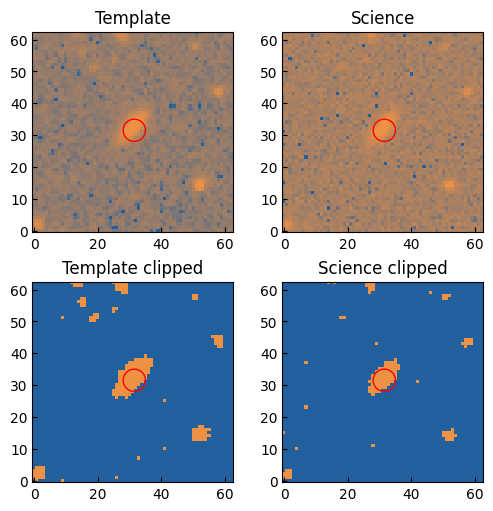

In [41]:
#Host example: https://fink-portal.org/ZTF23aaptfsu
fig,ax=plt.subplots(2,2,figsize=(5,5),layout='constrained')

circle1 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle2 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle3 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle4 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)

#Not clipped
image_data0 = np.frombuffer(obj_data_host['b:cutoutTemplate_stampData_stacked'].values[0], 
                            dtype="float32").reshape(63, 63)
image_data1 = np.frombuffer(obj_data_host['b:cutoutScience_stampData_stacked'].values[0], 
                                    dtype="float32").reshape(63, 63)
norm0 = simple_norm(image_data0, 'log', percent=99.)
norm1 = simple_norm(image_data1, 'log', percent=99.)

#Clipped
#print(monster_df['template_clipped'][i])
image_data2 = np.frombuffer(obj_data_host['template_clipped'].values[0], 
                            dtype="float64").reshape(63, 63)
image_data3 = np.frombuffer(obj_data_host['science_clipped'].values[0], 
                            dtype="float64").reshape(63, 63)
norm2 = simple_norm(image_data2, 'log', percent=99.)
norm3 = simple_norm(image_data3, 'log', percent=99.)
                
ax[0][0].imshow(image_data0,norm=norm0, origin='lower',interpolation='nearest',
                       cmap=cmap)
ax[0][1].imshow(image_data1,norm=norm1, origin='lower',interpolation='nearest',
                      cmap=cmap)
ax[0][0].set_title('Template')
ax[0][1].set_title('Science')

ax[1][0].imshow(image_data2,norm=norm2, origin='lower', interpolation='nearest',
                      cmap=cmap)
ax[1][1].imshow(image_data3,norm=norm3, origin='lower', interpolation='nearest',
                       cmap=cmap)
ax[1][0].set_title('Template clipped')
ax[1][1].set_title('Science clipped')

ax[0][0].add_patch(circle1)
ax[0][1].add_patch(circle2)
ax[1][0].add_patch(circle3)
ax[1][1].add_patch(circle4)

ax[0][0].tick_params(axis='both',direction='in')
ax[0][1].tick_params(axis='both',direction='in')
ax[1][0].tick_params(axis='both',direction='in')
ax[1][1].tick_params(axis='both',direction='in')
#plt.savefig('EG_success_host.pdf')
plt.show()
            

In [42]:
obj_data_hostless = monster_df[monster_df["objectId"] == 'ZTF23abbsfxp']

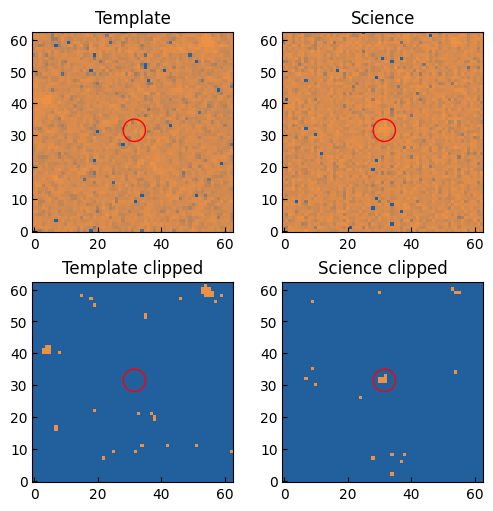

In [44]:
#No host example: https://fink-portal.org/ZTF23abbsfxp
fig,ax=plt.subplots(2,2,figsize=(5,5),layout='constrained')

circle1 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle2 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle3 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle4 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)

#Not clipped
image_data0 = np.frombuffer(obj_data_hostless['b:cutoutTemplate_stampData_stacked'].values[0], 
                            dtype="float32").reshape(63, 63)
image_data1 = np.frombuffer(obj_data_hostless['b:cutoutScience_stampData_stacked'].values[0], 
                            dtype="float32").reshape(63, 63)
norm0 = simple_norm(image_data0, 'log', percent=99.)
norm1 = simple_norm(image_data1, 'log', percent=99.)

#Clipped
image_data2 = np.frombuffer(obj_data_hostless['template_clipped'].values[0], 
                            dtype="float64").reshape(63, 63)
image_data3 = np.frombuffer(obj_data_hostless['science_clipped'].values[0], 
                            dtype="float64").reshape(63, 63)
norm2 = simple_norm(image_data2, 'log', percent=99.)
norm3 = simple_norm(image_data3, 'log', percent=99.)
                
ax[0][0].imshow(image_data0,norm=norm0, origin='lower',interpolation='nearest',
                      cmap=cmap)
ax[0][1].imshow(image_data1,norm=norm1, origin='lower',interpolation='nearest',
                       cmap=cmap)
ax[0][0].set_title('Template')
ax[0][1].set_title('Science')

ax[1][0].imshow(image_data2,norm=norm2, origin='lower', interpolation='nearest',
                       cmap=cmap)
ax[1][1].imshow(image_data3,norm=norm3, origin='lower', interpolation='nearest',
                       cmap=cmap)
ax[1][0].set_title('Template clipped')
ax[1][1].set_title('Science clipped')
ax[0][0].add_patch(circle1)
ax[0][1].add_patch(circle2)
ax[1][0].add_patch(circle3)
ax[1][1].add_patch(circle4)

ax[0][0].tick_params(axis='both',direction='in')
ax[0][1].tick_params(axis='both',direction='in')
ax[1][0].tick_params(axis='both',direction='in')
ax[1][1].tick_params(axis='both',direction='in')
#plt.savefig('EG_success_no_host.pdf')
plt.show()

In [150]:
obj_data_bug = monster_df[monster_df["objectId"] == 'ZTF22abbausm']

In [151]:
from copy import deepcopy
obj2 = deepcopy(obj_data_bug)

In [145]:
from ast import literal_eval
a = obj_data_bug['b:cutoutScience_stampData_stacked'].values[0]

In [149]:
b = np.frombuffer(a, dtype="float32")

In [121]:
a = np.frombuffer(a, 
                  dtype="float32").reshape(63, 63)
b = np.frombuffer(obj_data_bug['b:cutoutScience_stampData_stacked'].values[0], 
                            dtype="float32").reshape(63, 63)

TypeError: a bytes-like object is required, not '_io.BytesIO'

In [153]:
obj2['b:cutoutTemplate_stampData_stacked'] = \
    np.frombuffer(obj_data_bug['b:cutoutTemplate_stampData_stacked'].values[0], dtype="float32")
obj2['b:cutoutScience_stampData_stacked'] = \
    np.frombuffer(obj_data_bug['b:cutoutScience_stampData_stacked'].values[0], dtype="float32")

ValueError: Length of values (3969) does not match length of index (1)

In [120]:
a = BytesIO(obj_data_bug['b:cutoutTemplate_stampData_stacked'].values)

In [142]:
a

'[[217.06732 221.92664 231.3133  ... 222.23207 212.6207  209.27368]\n [242.21808 211.6203  194.10645 ... 225.96767 211.52637 205.55618]\n [226.01141 214.9419  209.22552 ... 229.54349 198.0556  242.53444]\n ...\n [213.63666 208.5592  198.07062 ... 209.54662 216.38202 249.6829 ]\n [204.60529 222.78497 203.29901 ... 205.29065 205.8994  240.4484 ]\n [202.77826 206.71387 208.81555 ... 230.35516 231.89774 231.28925]]'

In [127]:
from io import BytesIO
obj_data_bug = pd.read_csv('../data/ZTF22abbausm.csv')

In [102]:
obj2.to_csv('../data/ZTF22abbausm.csv')

TypeError: a bytes-like object is required, not 'str'

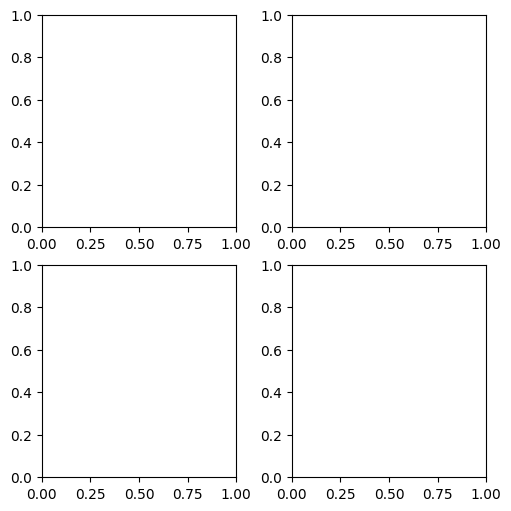

In [106]:
#No host bad detection example: https://fink-portal.org/ZTF22abbausm
fig,ax=plt.subplots(2,2,figsize=(5,5),layout='constrained')

circle1 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle2 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle3 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle4 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)


#Not clipped
image_data0 = np.frombuffer(obj_data_bug['b:cutoutTemplate_stampData_stacked'].values[0], 
                            dtype="float32").reshape(63, 63)
image_data1 = np.frombuffer(obj_data_bug['b:cutoutScience_stampData_stacked'].values[0], 
                            dtype="float32").reshape(63, 63)
norm0 = simple_norm(image_data0, 'log', percent=99.)
norm1 = simple_norm(image_data1, 'log', percent=99.)

#Clipped
#print(monster_df['template_clipped'][i])
image_data2 = np.frombuffer(obj_data_bug['template_clipped'].values[0], 
                            dtype="float64").reshape(63, 63)
image_data3 = np.frombuffer(obj_data_bug['science_clipped'].values[0], 
                            dtype="float64").reshape(63, 63)
norm2 = simple_norm(image_data2, 'log', percent=99.)
norm3 = simple_norm(image_data3, 'log', percent=99.)
                
ax[0][0].imshow(image_data0,norm=norm0, origin='lower',interpolation='nearest',
                       cmap=cmap)
ax[0][1].imshow(image_data1,norm=norm1, origin='lower',interpolation='nearest',
                       cmap=cmap)
ax[0][0].set_title('Template')
ax[0][1].set_title('Science')

ax[1][0].imshow(image_data2,norm=norm2, origin='lower', interpolation='nearest',
                       cmap=cmap)
ax[1][1].imshow(image_data3,norm=norm3, origin='lower', interpolation='nearest',
                       cmap=cmap)
ax[1][0].set_title('Template clipped')
ax[1][1].set_title('Science clipped')

ax[0][0].add_patch(circle1)
ax[0][1].add_patch(circle2)
ax[1][0].add_patch(circle3)
ax[1][1].add_patch(circle4)

ax[0][0].tick_params(axis='both',direction='in')
ax[0][1].tick_params(axis='both',direction='in')
ax[1][0].tick_params(axis='both',direction='in')
ax[1][1].tick_params(axis='both',direction='in')
#plt.savefig('EG_fail.pdf')
plt.show()

In [55]:
obj_data_bug['b:cutoutTemplate_stampData_stacked'].values[0].encode()

b'b\'\\xce\\x80WCO\\x97ZCQvXCV?XC\\x84jXCh2YC\\xd2\\xe3VC\\xe0\\xcfZCK<YC\\xa0\\xe9WC~\\x9cWC\\x15pWC\\x18RYC\\xca4YC<\\xe5UC\\xf0\\x9dVCh\\xdaWC,\\x8fZC:|UC\\x10\\xb0VC\\x96<XCp&WC \\xdcXC\\xfdqWCE\\xafYC\\xb4\\xccVC\\xa0\\x96UC\\xf4\\x82UC\\xe4\\xe2XC 8ZC\\xe8\\xcdUC\\xe2\\xeaVC|\\xa5XC\\xc6\\xdcZC\\xca\\xb1[C\\x16\\x85XC<\\xd0VC\\x0b\\x82VC\\xb0dXC\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfeB5ZC}MWC8\\x94UC\\xfa0WC\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\xff\\xff\\xff\\xfe\\x10%XC2=YC\\x1e\\xeaTCh"XC\\x101XCD\\xa3XC\\xc7\\x90XC\\x97\\x7f[C\\xacYYC\\xf2\\xe3XC\\xd6\\xe9UC\\xf5xXC\\xe8YYC8sYC\\xd09ZC@\\xdfYCR\\xc3WC\\xf5\\nVC \\x8eWC\\xf9\\xe9UC*\\xecXC\\x80\\xaeVC\\xd6\\x10XC;\\xffYC\\xac\\xd